<a href="https://colab.research.google.com/github/Tiana0117/Music-Genre-Classification-Model-REST-API/blob/main/Music_Classifier_Nov_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Classifier Step 3: Tensorflow Datasets

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for embedding viz
import plotly.express as px 
import plotly.io as pio
pio.templates.default = "plotly_white"

First, we read in the data downloaded from Kaggle and get an inspection on one of the lyrics.

In [2]:

url = 'https://raw.githubusercontent.com/jiahao303/music-classifier/main/tcc_ceds_music.csv'

df = pd.read_csv(url)

In [3]:

df = df.drop("Unnamed: 0", axis =1)
df.at[5,"lyrics"]

'convoy light dead ahead merchantmen trump diesels hammer oily kill grind knuckle white eye alight slam hatch deadly night cunning chicken lair hound hell devil care run silent run deep final prayer warriors secret sleep merchantman nightmare silent death lie wait run silent run deep sink final sleep chill hearts fight open ocean wonder lethal silver fish boat shiver cast millions play killer victim fool obey order rehearse lifeboat shatter hull tear black smell burn jones eye watch crosswire tube ready medal chest weeks dead like rest run silent run deep final prayer warriors secret sleep merchantman nightmare'

We found that most of the neutral words such as pronouns (i.e. we, you, I) and auxiliaries are omitted since they have no use for the sentiment identifying.

Also, we want to focus on music that are recently released, so we filter out the songs released before 2000.

In [4]:
df = df[df["release_date"] > 2000]

Now we get the dataframe resorted and only keep the lyrics column and the sentiment/topic column.

In [5]:
sentiment = df[["lyrics", "topic"]]
sentiment

,lyrics,topic
4843,yeah thinkin thoughts mind gonna finger gonna ...,obscene
4844,want learn reach grab cause everybody want bab...,obscene
4845,head head head head head head head head head h...,violence
4846,mechakucha odotte sawago sawago headbanger yea...,obscene
4847,want come cause room drink half beer right thi...,night/time
...,...,...
28367,cause fuck leave scar tick tock clock come kno...,obscene
28368,minks things chain ring braclets yap fame come...,obscene
28369,get ban get ban stick crack relax plan attack ...,obscene
28370,check check yeah yeah hear thing call switch g...,obscene


Our task will be to teach an algorithm to classify lyrics by predicting the topic based on the text of the lyrics.

In [6]:
sentiment.groupby("topic").size()

topic
feelings       193
music          515
night/time     575
obscene       2562
romantic       276
sadness       1874
violence      2373
world/life    1661
dtype: int64

Encode the "topic" column values with integers.

In [7]:
le = LabelEncoder()
sentiment["topic"] = le.fit_transform(sentiment["topic"])
sentiment.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,lyrics,topic
4843,yeah thinkin thoughts mind gonna finger gonna ...,3
4844,want learn reach grab cause everybody want bab...,3
4845,head head head head head head head head head h...,6
4846,mechakucha odotte sawago sawago headbanger yea...,3
4847,want come cause room drink half beer right thi...,2


Inspect which integers correspond to which classes using the classes_ attribute of the encoder.

In [8]:
le.classes_

array(['feelings', 'music', 'night/time', 'obscene', 'romantic',
       'sadness', 'violence', 'world/life'], dtype=object)

In [9]:
data = tf.data.Dataset.from_tensor_slices((sentiment["topic"],sentiment["lyrics"]))

Iterate over the data values.

In [10]:
for lyrics,topic in data.take(5):
    print(lyrics)
    print(topic)
    print("")

tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(b'yeah thinkin thoughts mind gonna finger gonna raise smilin thinkin thoughts give somethin give nothin write songs write week sleep thing dream thing need cause city everybody know fuckin true know wouldn understand doin everythin think thinkin thoughts mind gonna finger gonna raise smilin thinkin thoughts move people space write album song hear gotta feel cause city everybody know fuckin true know wouldn understand doin everythin think thinkin thoughts mind gonna finger gonna raise smilin thinkin thoughts yeah thinkin thoughts brain gonna dancin till legs start break smilin bein fake thinkin thoughts thinkin thoughts', shape=(), dtype=string)

tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(b'want learn reach grab cause everybody want baby shoot star baby heart break need play monastic blow cause everybody want barely know heart break photograph photograph photograph cause everybody want dream barely heart break photograph photograph photog

We have created a special TensorFlow Dataset.
Now, we will split it into training, validation, and testing sets.

In [11]:
data = data.shuffle(buffer_size = len(data))

In [12]:
train_size = int(0.7*len(data))
val_size   = int(0.1*len(data))

train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size)

In [13]:
len(train), len(val), len(test)

(7020, 1002, 2007)

In [14]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

In [15]:
max_tokens = 2000
# each headline will be a vector of length 40
sequence_length = 40

vectorize_layer = TextVectorization(
    max_tokens = max_tokens,
    standardize=standardization,
    output_mode='int',
    output_sequence_length=sequence_length)

We need to adapt the vectorization layer to the lyrics. In the adaptation process, the vectorization layer learns what words are common in the lyrics.

In [16]:
lyrics = train.map(lambda x, y: y)
vectorize_layer.adapt(lyrics)

We define a helper function that operates on our Datasets. Note that our Dataset consists of a bunch of tuples of the form (topic, lyrics) for each data observation. Our helper function therefore accepts and returns two variables.

In [17]:
def vectorize_headline(label, text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), [label]

train_vec = train.map(vectorize_headline)
val_vec   = val.map(vectorize_headline)
test_vec  = test.map(vectorize_headline)

Let's take a look at a vectorized piece of text.

In [18]:
list(train_vec.take(2))

[(<tf.Tensor: shape=(1, 40), dtype=int64, numpy=
  array([[   1,    1,    1,    1,  181,    1,    1,    1,    1,  472, 1180,
          1797, 1666,  688,  622,    1,    1,  606,  606,    1,    1,  105,
          1440,    1,    1,    1,    1,  688,  622,    1,    1,    1,    1,
           404,  111,    1, 1021,    1,  614,    1]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([7])>),
 (<tf.Tensor: shape=(1, 40), dtype=int64, numpy=
  array([[   7,   11,   11,  101,  232,   13,  405,   40,   65, 1507,   48,
            95,   29,    1,   84,   83, 1833,    1,    1,    3,   11,   11,
             9,   60,   14,   19,   27,  274,   18,  229,  348,  229,    1,
            84,   83, 1833,    1,    1,  156,   53]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

Great! Now our data are ready for TensorFlow to understand! We have represented each of our lyrics as numerical vectors.

## Modeling 1: Classifying Sentiment with lyrics input
Let's now construct a machine learning model out of some layers. This model is going to have a few new components
- `layers.Embedding()` which turns positive integers (indices) into dense vectors of fixed size.
- `layers.Dropout()` which deals with overfitting by ensuring that the model doesn't fit too close.
- `layers.GlobalAveragePooling1D()` 
- `layers.Dense()` which forms the prediction.

In [19]:
model = tf.keras.Sequential([
  layers.Embedding(max_tokens, output_dim = 8, name="embedding"),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(8) ]# we have 8 topics
)

In [20]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam', 
              metrics=['accuracy'])

In [21]:
history = model.fit(train_vec, epochs = 30, validation_data = val_vec)

Epoch 1/30
7020/7020 [==============================] - 37s 5ms/step - loss: 1.6063 - accuracy: 0.4383 - val_loss: 1.2233 - val_accuracy: 0.6477
Epoch 2/30
7020/7020 [==============================] - 35s 5ms/step - loss: 1.0535 - accuracy: 0.6745 - val_loss: 0.8088 - val_accuracy: 0.7625
Epoch 3/30
7020/7020 [==============================] - 34s 5ms/step - loss: 0.7894 - accuracy: 0.7489 - val_loss: 0.6007 - val_accuracy: 0.8204
Epoch 4/30
7020/7020 [==============================] - 34s 5ms/step - loss: 0.6594 - accuracy: 0.7939 - val_loss: 0.5351 - val_accuracy: 0.8433
Epoch 5/30
7020/7020 [==============================] - 34s 5ms/step - loss: 0.5883 - accuracy: 0.8095 - val_loss: 0.4371 - val_accuracy: 0.8832
Epoch 6/30
7020/7020 [==============================] - 34s 5ms/step - loss: 0.5376 - accuracy: 0.8286 - val_loss: 0.4623 - val_accuracy: 0.8523
Epoch 7/30
7020/7020 [==============================] - 34s 5ms/step - loss: 0.5150 - accuracy: 0.8336 - val_loss: 0.3583 - val_ac

Let's plot the training history of our model using `matplotlib`.

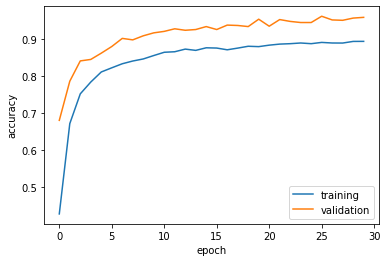

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

Awesome! We can observe that the validation accuracy stabilizes around 95% level, which is a pretty decent number. We also note that the test accuracy is less than the validation accuracy, so our model does not suffer from the overfitting issue.

## Visualizing Word Embeddings
A word embedding refers to a representation of a word in a vector space. The general aim of a word embedding is to create a representation such that words with related meanings are close to each other in a vector space, while words with different meanings are farther apart.

Let's take a look at the embedding layer to see how our own model represents words in a vector space.

In [ ]:
weights = model.get_layer('embedding').get_weights()[0] # get the weights from the embedding layer
vocab = vectorize_layer.get_vocabulary()                # get the vocabulary from our data prep for later

In [ ]:
weights

array([[ 1.0078984e-03,  4.3143664e-02,  5.0635923e-02, ...,
         2.0074757e-02,  1.5545160e-02,  1.4925542e-02],
       [-6.9395332e-03, -1.7521566e-01, -9.5930388e-03, ...,
        -2.2218477e-02, -1.4746561e-02, -4.4698950e-02],
       [ 9.4262582e-01,  7.3680031e-01,  4.6395734e-01, ...,
         3.1294155e-01, -3.0061886e-01, -1.9835454e-01],
       ...,
       [-1.7569466e-01,  2.0292699e-01,  1.2943841e+00, ...,
         1.4012630e-01, -2.0724649e+00,  1.1563767e+00],
       [ 9.9055362e-01,  6.6489637e-01,  1.7005172e+00, ...,
         1.4415875e-01, -8.0399692e-01,  8.9822644e-01],
       [-1.0192233e+00,  3.6956862e-01, -2.1617372e+00, ...,
         1.1533425e+00, -9.6115600e-03, -6.7640251e-01]], dtype=float32)

We chose to create a 8-dimensional embedding when constructing our model as there are 8 different topics for the lyrics. To plot in 2 dimensions, we need to reduce the data to a 2d representation. A very simple and standard approach is the principal component analysis (PCA).

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

Now we can make a dataframe from our results.

In [ ]:
embedding_df = pd.DataFrame({
    'word' : vocab, 
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})
embedding_df

,word,x0,x1
0,,-0.753292,-0.470212
1,[UNK],-0.864310,-0.572696
2,like,0.406027,-0.232887
3,know,-0.577440,-0.941501
4,time,-1.572505,-2.268851
...,...,...,...
1995,cyaa,-0.065479,-0.983136
1996,corn,-1.169721,-1.670360
1997,contagious,0.965837,-2.118966
1998,cameras,1.200207,-1.433753


In [ ]:
import plotly.express as px 
fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 size = list(np.ones(len(embedding_df))),
                 size_max = 2,
                 hover_name = "word")

fig.show()

Cool, we made a word embedding! This embedding seems to have learned some reasonable associations. For example, we see that words like "Someday", "Moment", and "Yesterday" are relatively close to each other and usually fall under the "night/time" label. So are "Dirt", "Ruin", and "Deny", which are usually related to a "sadness" topic song.

# Modeling 2: Classifying Genre with audio file

First, let's take a look at the values in `genre` .

In [19]:
df.groupby("genre").size()

genre
blues      1634
country    1308
hip hop     861
jazz       1356
pop        2199
reggae     1242
rock       1429
dtype: int64

Then, we go to the categorical encoding for the `genre` column. This step will help us to build the model in the future.

In [20]:
le2 = LabelEncoder()
df["genre"] = le2.fit_transform(df["genre"])
num_genres = len(df["genre"].unique())

We define the scalars, which will be the predictive data for our model.

In [21]:
scalars = ['dating', 
           'violence', 
           'world/life', 
           'night/time',
           'shake the audience',
           'family/gospel', 
           'romantic', 
           'communication',
           'obscene', 
           'music', 
           'movement/places', 
           'light/visual perceptions',
           'family/spiritual', 
           'like/girls', 
           'sadness', 
           'feelings', 
           'danceability',
           'loudness', 
           'acousticness', 
           'instrumentalness', 
           'valence', 
           'energy']        

The model uses scalars as predictive data and genre as the target data.

In [22]:
data = tf.data.Dataset.from_tensor_slices(
    (
        {
            "lyrics" : df[["lyrics"]], 
            "scalars" : df[scalars]
        }, 
        {
            "genre" : df[["genre"]]
        }
    )
)

We perform train/test/validation split. 

In [23]:
data = data.shuffle(buffer_size = len(data))

train_size = int(0.7*len(data))
val_size   = int(0.1*len(data))

train = data.take(train_size).batch(20)
val   = data.skip(train_size).take(val_size).batch(20)
test  = data.skip(train_size + val_size).batch(20)

len(train), len(val), len(test)

(351, 51, 101)

In [24]:
size_vocabulary = 2000

vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens= size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500) 

vectorize_layer.adapt(train.map(lambda x, y: x["lyrics"]))

In [25]:
scalars_input = keras.Input(
    shape = (len(scalars),), 
    name = "scalars",
    dtype = "float64"
)

In [26]:
lyrics_input = keras.Input(
    shape = (1,), 
    name = "lyrics",
    dtype = "string"
)

In [27]:
lyrics_features = vectorize_layer(lyrics_input)
lyrics_features = layers.Embedding(size_vocabulary, 7, name = "embedding")(lyrics_features)
lyrics_features = layers.Dropout(0.2)(lyrics_features)
lyrics_features = layers.GlobalAveragePooling1D()(lyrics_features)
lyrics_features = layers.Dropout(0.2)(lyrics_features)
lyrics_features = layers.Dense(64, activation='relu')(lyrics_features)

In [28]:
scalar_features = layers.Dense(64, activation='relu')(scalars_input)

In the following part, we are going to concatenate the output derived from lyrics pipeline and scalars pipeline. 

In [29]:
main = layers.concatenate([lyrics_features, scalar_features], axis = 1)
main = layers.Dense(256, activation='relu')(main)
main = layers.Dense(64, activation='relu')(main)
main = layers.Dense(32, activation='relu')(main)
output = layers.Dense(num_genres, name = "genre", activation = 'softmax')(main)

In [30]:
model = keras.Model(
    inputs = [lyrics_input, scalars_input],
    outputs = output
)

So far, we have successfully built the model. Use the `plot_model()` function to take a look at the visualized structure of the model.

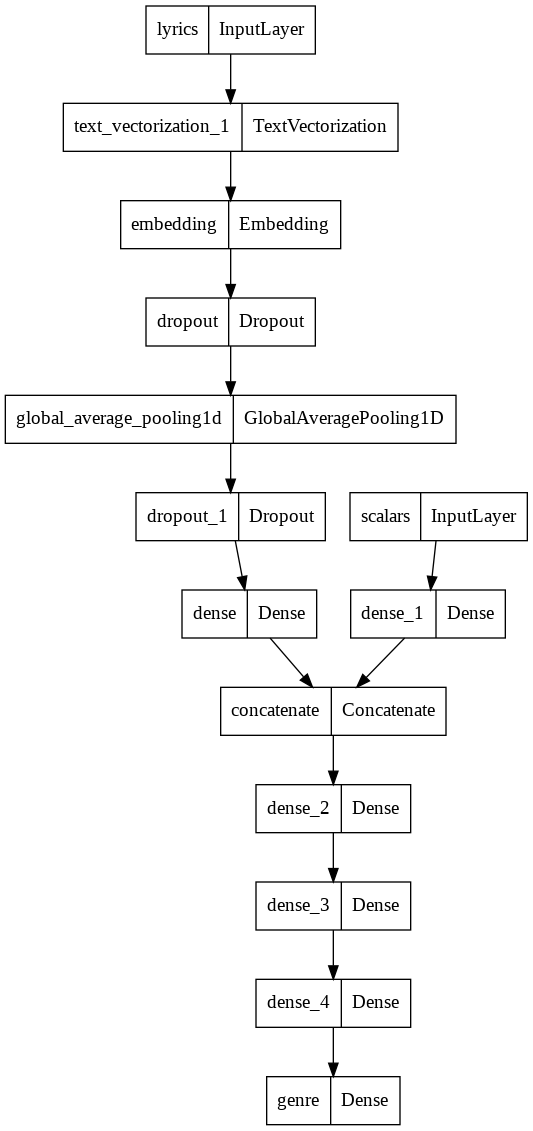

In [31]:
keras.utils.plot_model(model)

Then, we start to train and evaluate the model.

In [32]:
model.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
)

In [33]:
history = model.fit(train, 
                    validation_data=val,
                    epochs = 60, 
                    verbose = True)

Epoch 1/60
351/351 [==============================] - 6s 11ms/step - loss: 1.6704 - accuracy: 0.3266 - val_loss: 1.5705 - val_accuracy: 0.3493
Epoch 2/60
351/351 [==============================] - 3s 10ms/step - loss: 1.5478 - accuracy: 0.3912 - val_loss: 1.4512 - val_accuracy: 0.4381
Epoch 3/60
351/351 [==============================] - 3s 10ms/step - loss: 1.4772 - accuracy: 0.4311 - val_loss: 1.4306 - val_accuracy: 0.4411
Epoch 4/60
351/351 [==============================] - 3s 10ms/step - loss: 1.3899 - accuracy: 0.4704 - val_loss: 1.3494 - val_accuracy: 0.4741
Epoch 5/60
351/351 [==============================] - 3s 10ms/step - loss: 1.3587 - accuracy: 0.4869 - val_loss: 1.3434 - val_accuracy: 0.4870
Epoch 6/60
351/351 [==============================] - 3s 10ms/step - loss: 1.3162 - accuracy: 0.4993 - val_loss: 1.3165 - val_accuracy: 0.5150
Epoch 7/60
351/351 [==============================] - 3s 9ms/step - loss: 1.2856 - accuracy: 0.5197 - val_loss: 1.2052 - val_accuracy: 0.5399


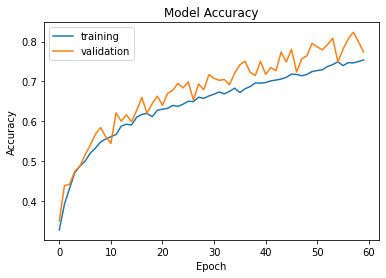

In [34]:
from matplotlib import pyplot as plt
# summarize history for accuracy
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["training","validation"], loc = "upper left")


## Pickling the model

In [43]:
from google.colab import drive
drive.mount('/content/gdrive')

model.save_weights('/content/gdrive/My Drive/fake_model')

# import pickle
# filename = '/content/gdrive/My Drive/fake_model.pkl'
# pickle.dump(model, open(filename, 'wb'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


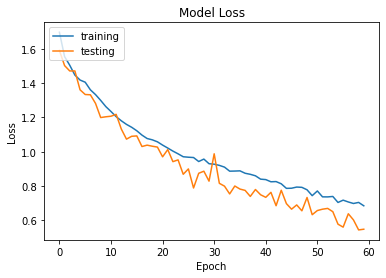

In [ ]:
# summarize history for loss
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'testing'], loc='upper left')
plt.show()